# Expectation-Maximization (EM) Algorithm
### Implementation and visualization of the EM algorithm.

In [112]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

# plot styling
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = 'DIN Alternate'

In [113]:
def init_cov(n):
    """ Generate initial covariance matrix """
    # ensures positive semi-definiteness
    x = np.random.standard_normal((n, n))
    return x @ x.T

In [114]:
def init_guess(n):
    """ Generates initial guess for all parameters """
    return {
        'pi': np.random.uniform(0, 1),
        'mu_1': np.random.standard_normal((n, )),
        'mu_2': np.random.standard_normal((n, )),
        'S_1': init_cov(n),
        'S_2': init_cov(n)
    }

In [115]:
def get_posteriors(x, p):
    """ Compute the posteriors """
    p_1 = multivariate_normal(p['mu_1'], p['S_1']).pdf(x)
    p_2 = multivariate_normal(p['mu_2'], p['S_2']).pdf(x)
    pi_1 = p['pi']
    pi_2 = 1 - pi_1
    P_1, P_2 = p_1 * pi_1, p_2 * pi_2
    Q_1 = P_1 / (P_1 + P_2)
    Q_2 = P_2 / (P_1 + P_2)
    return np.array([Q_1, Q_2]).T
    

In [116]:
def e_step(x, p):
    """ Compute expectation step """
    p_1 = multivariate_normal(p['mu_1'], p['S_1']).pdf(x)
    p_2 = multivariate_normal(p['mu_2'], p['S_2']).pdf(x)
    pi_1 = p['pi']
    pi_2 = (1 - p_1)
    return np.mean(np.log(pi_1 * p_1 + pi_2 * p_2)), get_posteriors(x, p)

In [117]:
def m_step(x, p):
    """ Compute maximization step """
    N = x.shape[0]
    _, post = e_step(x, p)
    post_1, post_2 = post[:, 0].reshape((N, 1)), post[:, 1].reshape((N, 1))
    tot_post_1, tot_post_2 = np.sum(post_1), np.sum(post_2)
    pi_1 = tot_post_1 / N
    mu_1 = (post_1.T.dot(x) / tot_post_1).flatten()
    mu_2 = (post_2.T.dot(x) / tot_post_2).flatten()
    D_1, D_2 = x - mu_1, x - mu_2
    S_1 = D_1.T.dot(D_1 * post_1) / tot_post_1
    S_2 = D_2.T.dot(D_2 * post_2) / tot_post_2
    return {
        'pi': pi_1,
        'mu_1': mu_1,
        'mu_2': mu_2,
        'S_1': S_1,
        'S_2': S_2
    }

In [118]:
def plot_cov_ellipse(mu, cov, ax, n_std=3, facecolor='none', **kwargs):
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2,
    height=ell_radius_y * 2, facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [119]:
def visualize_clusters(ax, params):
    """ Visualization of current clusters as ellipses """
    sns_colors = sns.color_palette().as_hex()
    plot_cov_ellipse(params['mu_1'], params['S_1'],\
        ax=ax, edgecolor=sns_colors[0], label='Group 1')
    plot_cov_ellipse(params['mu_2'], params['S_2'],\
         ax=ax, edgecolor=sns_colors[1], label='Group 2')

In [124]:
def run_em(x, p, tol=10e-8, iter_lim=100):
    """ Run the EM algorithm until convergence """
    _, axs = plt.subplots(3, 5, sharex=True, sharey=True)
    r, c = 0, 0
    log_lik = np.zeros(iter_lim)
    log_lik[0], _ = e_step(x, p)
    cnt = 1 # iter counter
    converged = False
    while not converged:
        p = m_step(x, p)
        log_lik[cnt], _ = e_step(x, p)
        if (cnt % 4 == 0) and ((cnt / 4) < 15):
            axs[r, c].scatter(x[:, 0], x[:, 1], color='grey')
            visualize_clusters(axs[r, c], p)
            axs[r, c].set_title('Iteration: {}'.format(cnt))
            plt.draw()
            c += 1
            if c > 4:
                r += 1
                c = 0
        if np.abs(log_lik[cnt] - log_lik[cnt - 1]) < tol:
            converged = True
            plt.scatter(x[:, 0], x[:, 1], color='grey')
            visualize_clusters(plt.gca(), p)
            plt.title('Convergence \n iteration: {}'.format(cnt))
        cnt += 1
        if cnt == iter_lim and not converged:
            return print('Convergence failure...')
    plt.gcf().set_size_inches(14, 8)
    return p, log_lik[log_lik != 0]

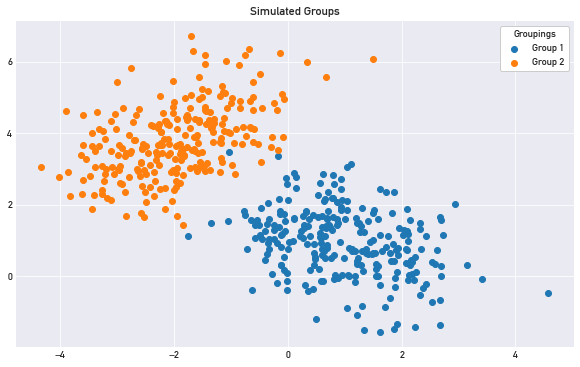

In [125]:
# simulate some data
np.random.seed(1337)
n = 250
mu_1, mu_2 = [1, 1], [-2, 3.75]
S_1, S_2 = [[1, -.4], [-.4, 1]], [[1, .5], [.5, 1]]
group_1 = np.random.multivariate_normal(mu_1, S_1, size=n)
group_2 = np.random.multivariate_normal(mu_2, S_2, size=n)
plt.scatter(group_1[:, 0], group_1[:, 1], label='Group 1')
plt.scatter(group_2[:, 0], group_2[:, 1], label='Group 2')
plt.legend(frameon=1, framealpha=1, facecolor='white', title='Groupings')
plt.title('Simulated Groups')
plt.gcf().set_size_inches(10, 6)
plt.show()

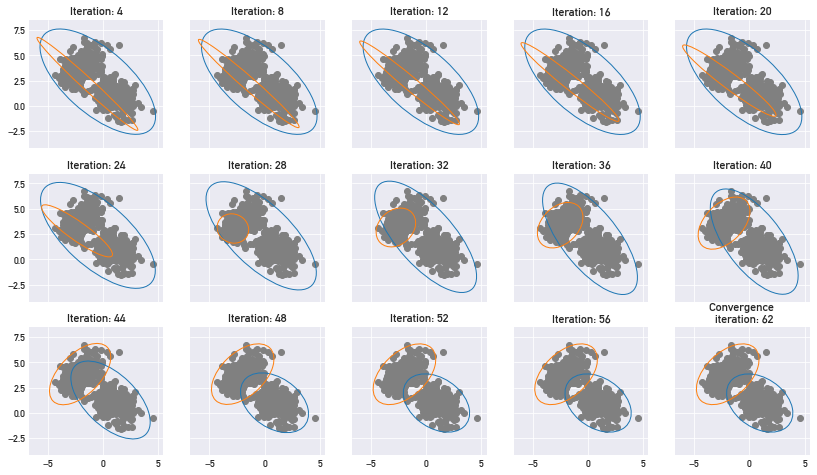

In [128]:
# for reproducibility
np.random.seed(137)

# stack data
dat = np.concatenate([group_1, group_2], axis=0)

# create labels 
labels = np.concatenate([np.ones((n, 1)), np.ones((n, 1)) * 2], axis=0)

# merge data with labels and shuffle
dat_l = np.concatenate([dat, labels], axis=1)
np.random.shuffle(dat_l)

# generate initial guess
K = 2
g = init_guess(K)

# run EM-algorithm!
res, mean_log_lik = run_em(dat_l[:, :-1], g)

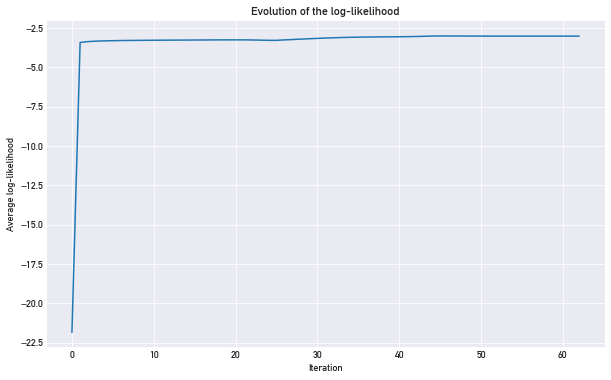

In [129]:
# check average log-likelihood
plt.plot(mean_log_lik)
plt.ylabel('Average log-likelihood')
plt.xlabel('Iteration')
plt.title('Evolution of the log-likelihood')
plt.gcf().set_size_inches(10, 6)
plt.show()